# Homework 6

**Due: 10/27/2020 on gradescope**

## References

+ Lectures 17-18 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as st
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Problem 1 - Clustering Uber Pickup Data

In this problem you will analyze Uber pickup data collected during April 2014 around New York City.
The complete data are freely on [Kaggle](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city/).
The data consist of a timestamp (which we are going to ignore), the latitude and longitude of the Uber pickup, and a base code (which we are also ignoring).
The data file we are going to use is [uber-raw-data-apr14.csv](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/datasets/uber-raw-data-apr14.csv).
As usual, you have to make it visible to this Jupyter notebook.
On Google Colab, just run this:

In [4]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/datasets/uber-raw-data-apr14.csv'
download(url)

And you can load it using pandas:

In [6]:
p1_data = pd.read_csv('uber-raw-data-apr14.csv')

Here is a text view:

In [7]:
p1_data

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764


As you see, there where about half a million Uber pickups during April 2014...
Let's extract the lattitude and longitude data only (this is needed for passing them to scikit-learn algorithms).
Here is how you can do this in pandas:

In [8]:
# Just use the column names as indices.
# The two brackets are required because you are actually
# passing a list of columns
loc_data = p1_data[['Lat', 'Lon']]
loc_data

,Lat,Lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722
...,...,...
564511,40.7640,-73.9744
564512,40.7629,-73.9672
564513,40.7443,-73.9889
564514,40.6756,-73.9405


Let's also visualize these points:

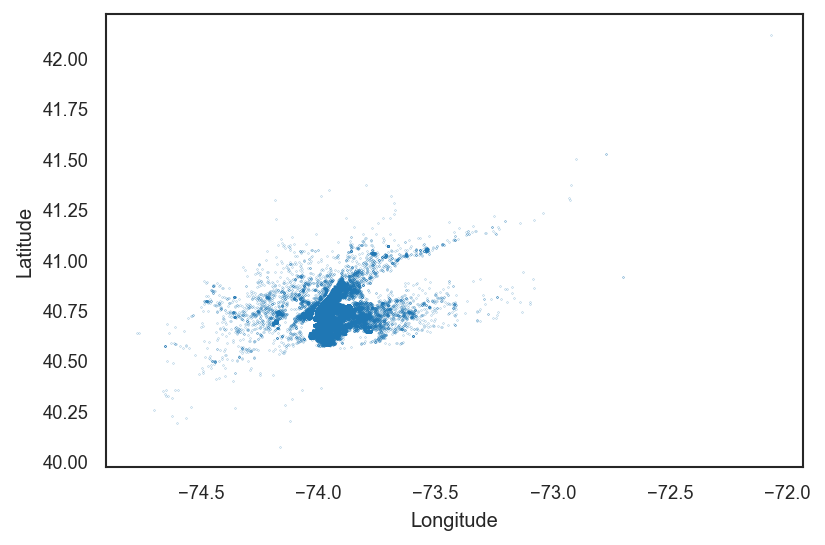

In [16]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(loc_data.Lon, loc_data.Lat, s=0.01)
# ``s=0.01`` specifies the size. I am using a small size because
# these are too many points to visualize
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

This is nice, but it would be even nicer if we had a map of New York City on the background.
We can make such a map on [www.openstreetmap.org](https://www.openstreetmap.org/export#map=11/40.7855/-73.8964).
We just need to have a box of longitude's and latitudes that overlaps with our data.
Here is how to get such a *bounding box*:

In [36]:
box = ((loc_data.Lon.min(), loc_data.Lon.max(),
        loc_data.Lat.min(), loc_data.Lat.max()))
box

(-74.7733, -72.0666, 40.0729, 42.1166)

I have already extracted this picture for you and you can find it [here](https://github.com/PredictiveScienceLab/data-analytics-se/blob/master/datasets/ny_map.png).
As always, it needs to be visible from the Jupyter notebook.
On Google Colab run:

In [52]:
url = 'https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/datasets/ny_map.png'
download(url)

If you have it at the right place, you should be able to see the image here:

![New York City Map](map_ny.png)

Now let's load the image as a matrix:

In [54]:
ny_map = plt.imread('ny_map.png')

And we can visualize it with ``plt.imshow`` and draw the Uber pickups on top of it.
Here is how:

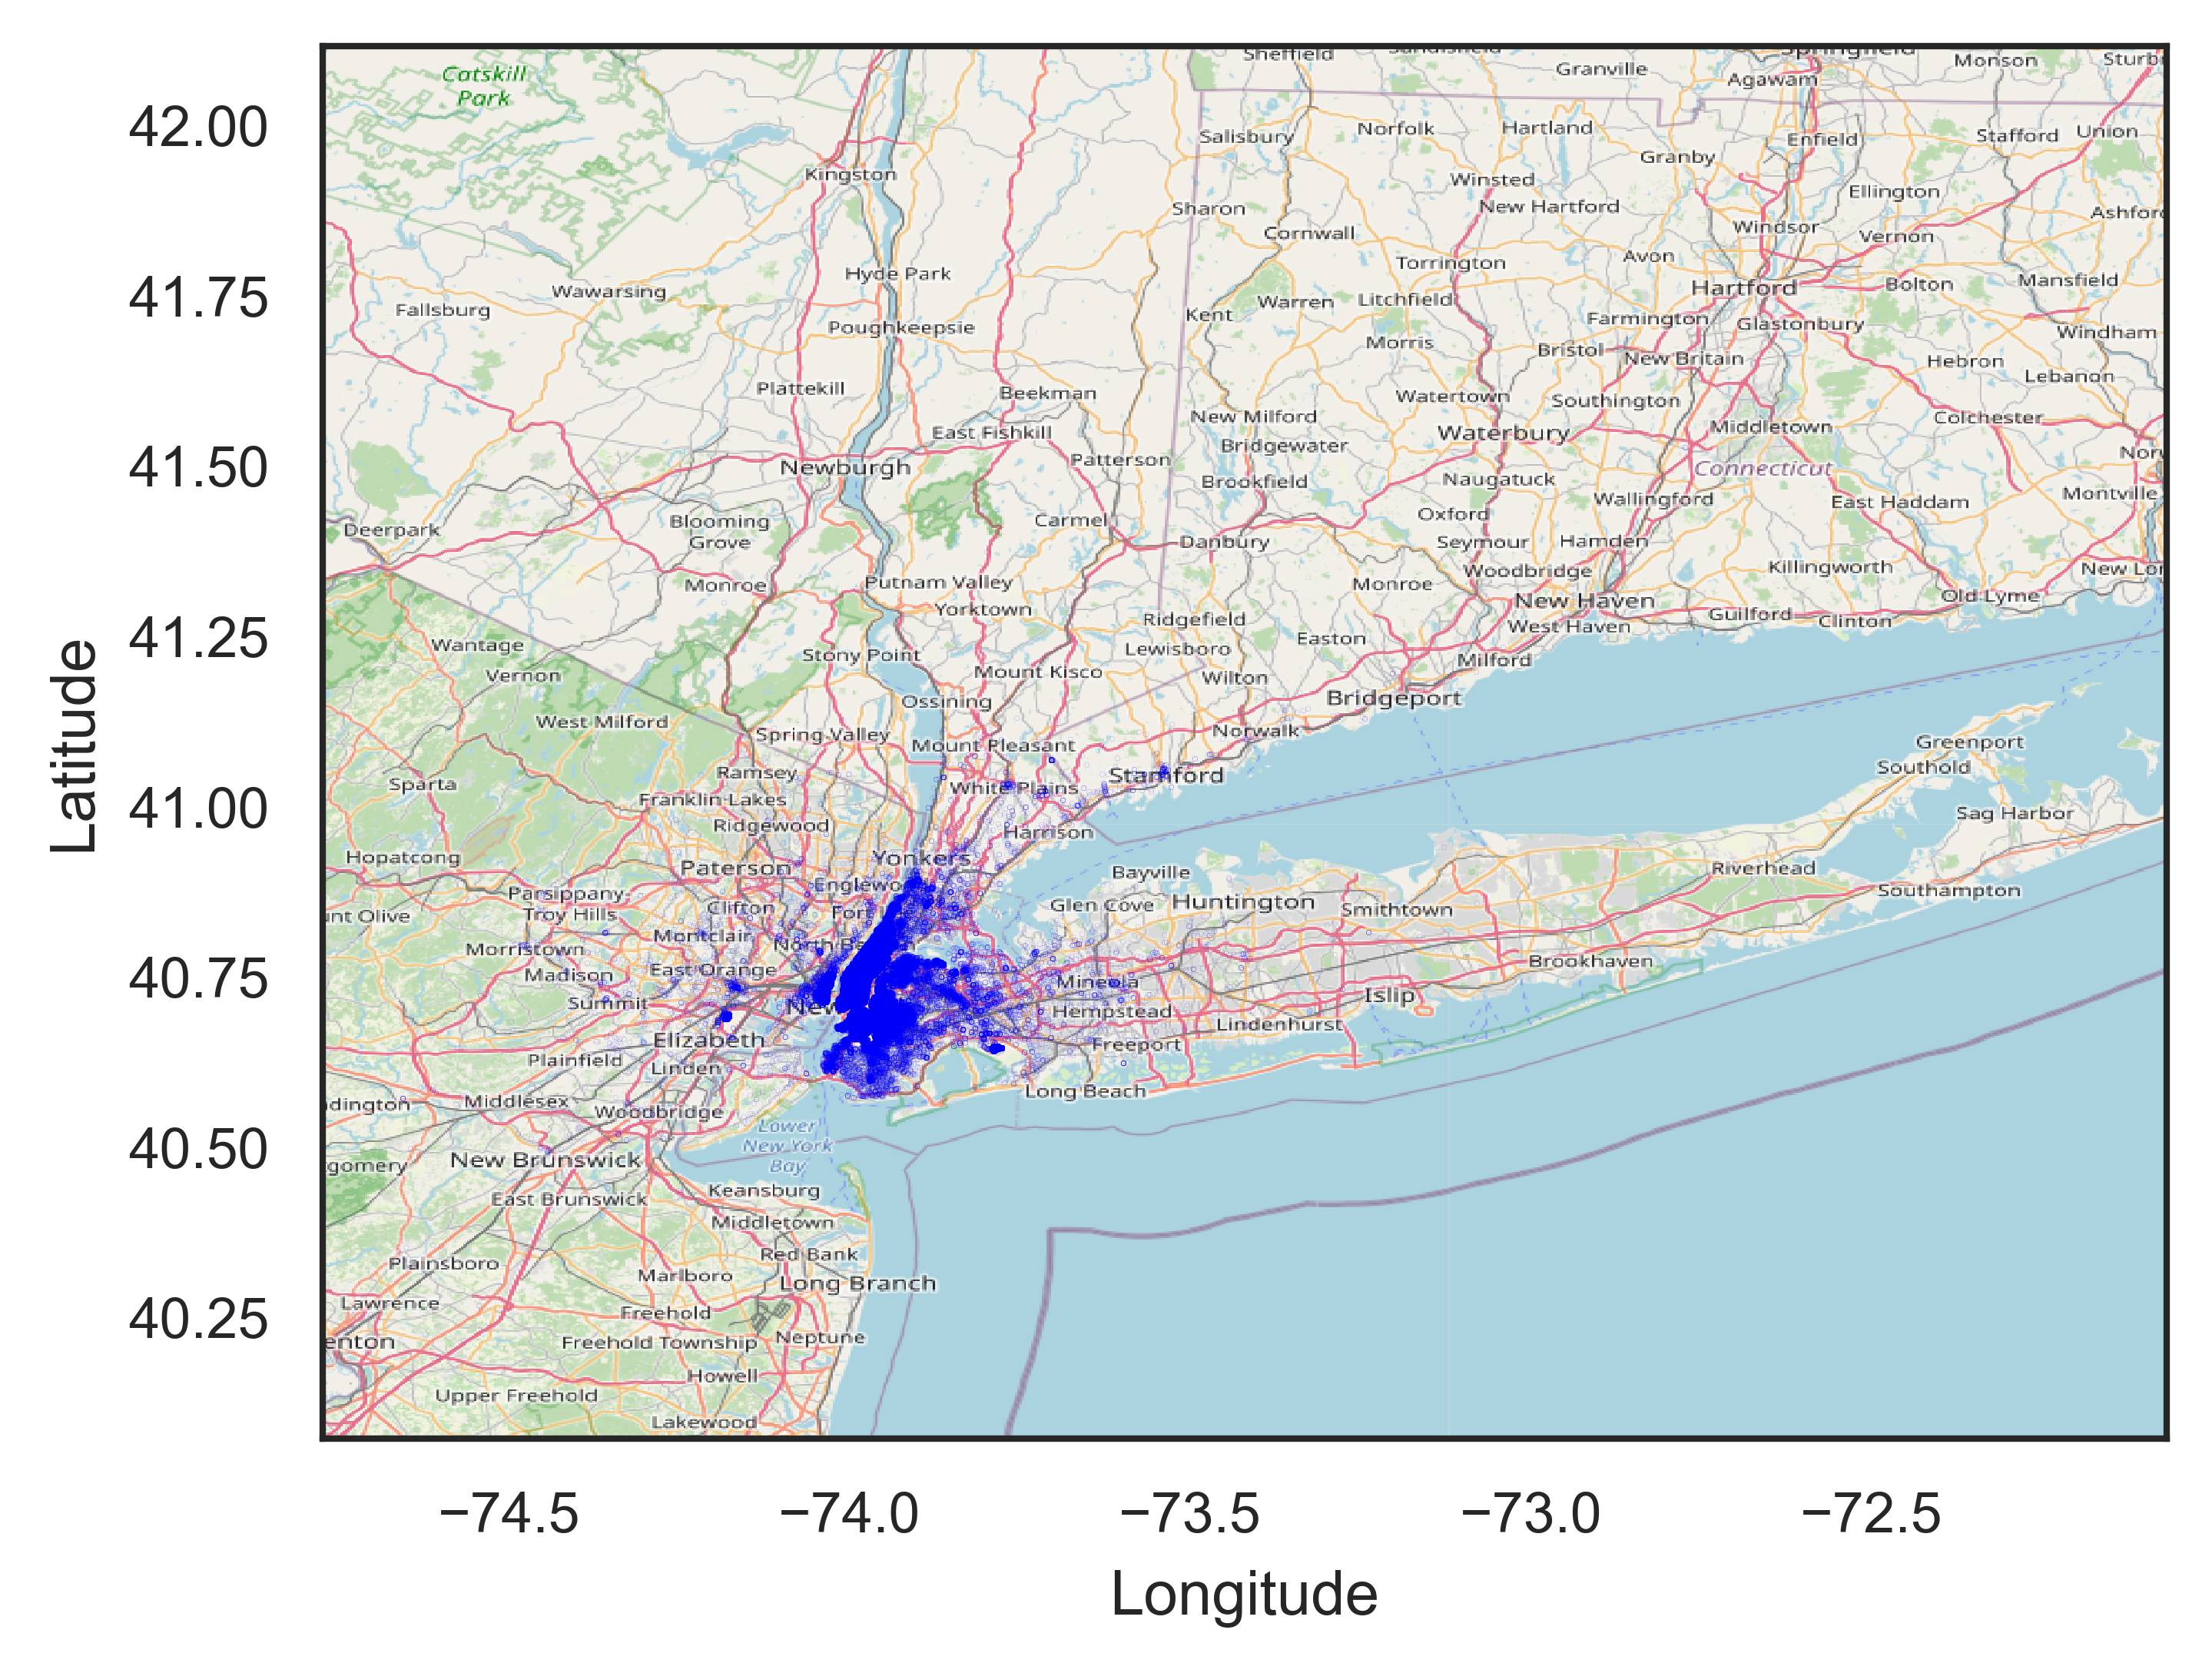

In [65]:
fig, ax = plt.subplots(dpi=600)
ax.scatter(loc_data.Lon, loc_data.Lat, zorder=1, alpha= 0.5, c='b', s=0.001)
ax.set_xlim(box[0],box[1])
ax.set_ylim(box[2],box[3])
ax.imshow(ny_map, zorder=0, extent=box, aspect= 'equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

Because we have over half a million data points, machine learning algorithms may be a bit slow.
So, as you develop your code use use only 50K observations.
Once you have a stable version of your code, modify the following code segment to make use of the entire dataset.

In [67]:
# While your are developing your code use this:
p1_train_data = loc_data[:100000]
# When you have a stable code, use this:
# p1_train_data = loc_data

## Part A - Splitting New York City into Subregions

Suppose that you are assigned the task of splitting New York City into operating subregions with pretty much equal demand.
When a pickup is requested in each subregion only the drivers in that region are called.
Note that this can quickly become a very difficult problem very quickly.
We are not looking for the best possible answer here.
This would require posing and solving a suitable optimization problem.
We are looking for a data-informed solution that is compatible with common sense.

Do (at least) the following:
+ Use Kmeans clustering on the pickup data with different number of clusters;
+ Visualize the labels of the clusters on the map using different colors (see the hands-on activities);
+ Visualize the centers of the discovered Kmeans clusters (in red color);
+ Use your common sense, e.g., make sure that you have enough clusters so that no region crosses the water (even if it is possible the drivers may have to pay tolls to cross). If it is impossible to get perfect results simply by Kmeans, feel free to ignore a small number of outliers as they could be handled manually;
+ Use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) which is an much faster version of Kmeans suitable for large datasets (>10K observations);

Answer with as many text blocks and code blocks as you like right below.

*Any text you like here*

In [68]:
# Your code here

## Part B - Create a Stochastic Model of Pickups

One of the key ingredients for a more sophisticated approach to optimizing the operations of Uber would involve the construction of a stochastic model of the demand for pickups.
The ideal model for this problem is the [Poisson Point Process](https://en.wikipedia.org/wiki/Poisson_point_process).
However, we are going to do something simpler, using the Gaussian mixture model and a Poisson random variable.
The model will not have a time component, but it will allow us to sample the number and locations of pickups during a typical month.
We will guide you through the process of constructing this model.

### Subpart B.I - Random variable capturing number of monthly pickups

Find the rate of monthly pickups (ignore the fact that months may differ by a few days) and use it to define a Poisson random variable corresponding to the monthly number of pickups.
Use ``scipy.stats.poisson`` to initialize this random variable. Sample from it 10,000 times and plot the histogram of the samples to get a feeling about the corresponding probability mass function.

In [69]:
# Your code here

### Subpart B.II - Estimate the spatial density of pickups

Fit a Gaussian Mixture model to the pickup data.
**Do not use the Bayesian Information Criterion** to decide how many components to keep.
This would take quit a bit of time for this problem. Simply use 40 mixture components.
Plot the contour of the logarithm of the probability density on the New York City map.

In [69]:
# Your code here

### Subpart B.III - Sample some random months of pickups

Now that you have a model that gives you the number of pickups and a model that allows you to sample a pickup location, sample five different datasets (number of pickups and location of each pick) from the combined model and visualize them on the New York map.

**Hint:** Don't get obsessed with making the model perfect. It's okay if a few of the pickups are on water...

In [70]:
# Your code here

# Problem 2 - Counting Celestial Objects

Consider [this picture]() of a patch of sky taken by the [Hubble Space Telescope](https://www.nasa.gov/mission_pages/hubble/story/index.html).

# Problem 3 - Quantifying Uncertainties in Steel Magnetic Properties

Write.

*Enter your model description/solution here. Delete that ``<br>`` line (it just makes some white space).*
<br><br><br><br><br><br><br><br><br><br>